<a href="https://colab.research.google.com/github/sirbastiano/BBlocks/blob/main/IADF_SAR_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Download the notebook](https://gitlab.telecom-paris.fr/ring/iadf-2023-sar-processing/-/raw/main/IADF_SAR_notebook.ipynb?inline=false) and then import it under Google Colab**

<a href="https://colab.research.google.com/" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IADF School 2023: Computer Vision for Earth Observation
# Practical session
## Synthetic Aperture Radar Data Analysis
### Florence Tupin, Emanuele Dalsasso

In this practical work you will be guided through a series of tools aiming at visualising and processing SAR data. First, you will implement a simple visualization tool do display the phase and amplitude information of a SAR image. Then, a statistical analysis to verify Goodman's model will be conducted. Finally, some speckle reduction algorithms will be implemented and the results analysed from both a qualitative and quantitative perspective.

Some of the tools that we will use can be found here:
https://gitlab.telecom-paris.fr/ring/

## 0. Download data and install needed libraries

In [1]:
!wget -O tools_ED.py https://osf.io/ukvr2/download
!wget https://perso.telecom-paristech.fr/dalsasso/TPSAR/mvalab.py


--2023-09-14 14:33:56--  https://osf.io/ukvr2/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/n2aym/providers/osfstorage/61a9e7b80db6590527834b7c?action=download&direct&version=15 [following]
--2023-09-14 14:33:57--  https://files.de-1.osf.io/v1/resources/n2aym/providers/osfstorage/61a9e7b80db6590527834b7c?action=download&direct&version=15
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3303 (3.2K) [application/octet-stream]
Saving to: ‘tools_ED.py’

tools_ED.py         100%[===================>]   3.23K  --.-KB/s    in 0s      

2023-09-14 14:33:58 (27.5 MB/s) - ‘tools_ED.py’ saved [3303/3303]

--2023-09-14 14:33:58--  https://perso.telecom-paristech.fr/dalsasso/TPS

In [2]:
from tools_ED import *
import scipy.io as sio
import mvalab
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from google_drive_downloader import GoogleDriveDownloader as gdd
import cmath
import copy
import scipy

plt.rcParams['figure.figsize'] = [8, 8]

## 1. Visualization of a SAR image
In this part, you will work a SAR image acquired over Paris by the TerraSAR-X sensor @DLR. Data are Single-Look Complex (SLC). For the following image, each pixel contains a complex value.


In [3]:
url='https://perso.telecom-paristech.fr/dalsasso/TPSAR/paris/'

image_name='Eiffel.CXF'
data_paris=mvalab.imz2mat(url+image_name)
ncol=data_paris[1]
nlin=data_paris[2]

image_array_paris = data_paris[0]

imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/dalsasso/TPSAR/paris/Eiffel.CXF
Nom compatible url
Nom compatible url
Complex float, Fichiers PC
INFO - reading header/dim : https://perso.telecom-paristech.fr/dalsasso/TPSAR/paris/Eiffel.dim
lecture .dim OK -> largeur:2048 hauteur:2048 profondeur:1
Debug 2 4 2048
4 2048 <f


Display the phase information. To this purpose, you can use the function `np.angle` which returns values in the range $(-\pi, +\pi]$.

TypeError: ignored

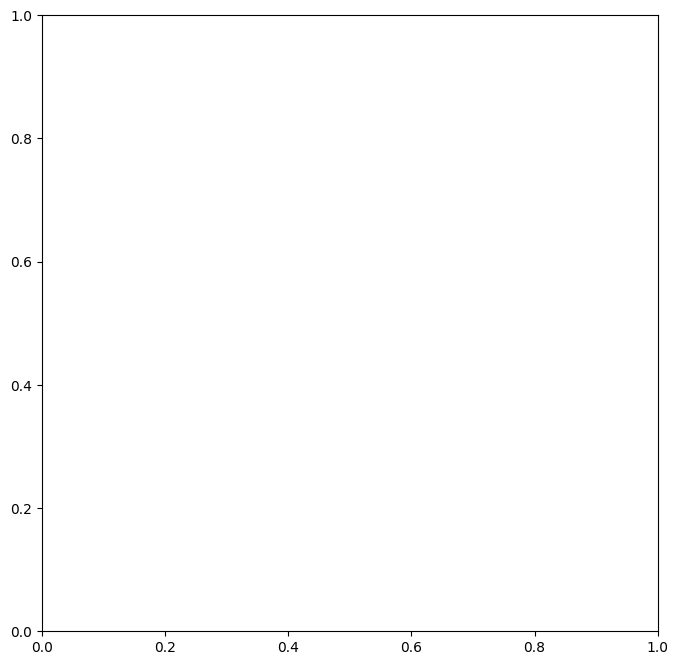

In [4]:
# visualization of the phase
phase_image_paris = ... # complete
plt.figure(figsize=(8,8))
plt.imshow(phase_image_paris, vmin=..., vmax=..., cmap='gray') # complete
plt.show()

Display the amplitude information using `matplotlib`. What can you observe? Plot the histogram to undestand why the displayed image looks like that.

**N.B.**: An amplitude image is given by the modulus of the electro-magnetic field and intensity is the square of the amplitude (proportional to the signal power).

In [ ]:
# naive visualization of amplitude with matplotlib
amplitude_image_paris = ... # complete
plt.figure(figsize=(8,8))
plt.imshow(amplitude_image_paris, cmap='gray')
plt.show()

In [ ]:
plt.figure()
plt.hist(np.ravel(amplitude_image_paris),bins='auto',density=True,range=(0,5000))
plt.show()

print('Range of a SAR image: ['+str(np.min(amplitude_image_paris))+'; '+str(np.max(amplitude_image_paris))+']')

Implement a tool to visualise the amplitude information of a SAR image based on its statistics. By convention, the relevant information **for visualization purposes** (not for processing purposes) is contained within the range $[0; \mu+3\times\sigma ]$

In [ ]:
def showsar(amplitude_data):
  threshold = ... # complete
  plt.figure()
  plt.imshow(amplitude_data, vmax=threshold, cmap='gray')
  plt.show()

showsar(amplitude_image_paris)

What is the position of the sensor relatively to the scene?

<img src="http://www.clker.com/cliparts/5/7/d/b/1195442352382851478zeimusu_Warning_sign.svg?display=inline-block" alt="drawing" width="20"/>Image providers produce images where the sensor is always on the **...**-side of the image. When at high-resolution (equal or less than 1 meter), the side-looking geometry of SAR images introduces visible distortions. Thus, flipping images to do data-augmentation might not be desirable.

In [ ]:
def showsar(amplitude_data,size_fig=8,title='',threshold=None):
  if threshold == None:
    threshold = ... # complete
  elif threshold == 0:
    threshold = np.max(amplitude_data)
  else:
    threshold = threshold

  title = title + ' : mean = '+str(np.mean(amplitude_data)) + ' std = '+str(np.std(amplitude_data))

  plt.figure(figsize=(size_fig,size_fig))
  plt.imshow(amplitude_data, vmax=threshold, cmap='gray')
  plt.title(title)
  plt.show()

In [ ]:
showsar(amplitude_image_paris,threshold=0)
showsar(amplitude_image_paris)


# 2. Single look data distributions
In this part, we will use an SLC (Single Look Complex) image $z=a+jb$ and analyze its pdf.
The image has been acquired by the Sentinel-1 sensor over the Lelystad zone (very flat area with fields crops).
Vizualize the amplitude image and interpret it. You may want to have a look to an [optical image](https://goo.gl/maps/JJcYcRjMKj1p6uqW8) of the area.


In [ ]:
pageweb="https://perso.telecom-paristech.fr/dalsasso/TPSAR/pilelely/"
image='Lely.CXF'
im_slc_senti_lely_liste=mvalab.imz2mat(pageweb+image);
im_slc_senti_lely = im_slc_senti_lely_liste[0]
ncol=im_slc_senti_lely_liste[1]
nlin=im_slc_senti_lely_liste[2]

showsar(np.abs(im_slc_senti_lely))

## 2.1 Data distributions for an homogeneous area
- Select a **physically** homogeneous area (you can zoom and see coordinates as you move the arrow on the image) and compute the distribution of the real part, imaginary part, phase, intensity and amplitude. Some useful functions are:
  - `np.angle`
  - `np.real`
  - `np.imag`

- Compute the histograms for these variables and draw on the histogram the theoretical curve by computing the mean value $\mu$ and the standard deviation $\sigma$ with the function `scipy.stats.[distribution].fit` by replacing `[distribution]` with the [expected pdf](https://docs.scipy.org/doc/scipy/reference/stats.html)
- Rembember:
  - $z = a+jb = Ae^\phi$: single-look complex SAR image
  - $a$: real part
  - $b$: imaginary part
  - $A=|z|=\sqrt{a^2+b^2}$: amplitude information
  - $\phi=\arctan(b/a)$: phase information
  - $I=A^2=|z|^2=a^2+b^2$: intensity information

<img src="http://www.clker.com/cliparts/5/7/d/b/1195442352382851478zeimusu_Warning_sign.svg?display=inline-block" alt="drawing" width="20"/> The Goodman model is valid only on homogeneous area. That is why it is important to select pixels sharing the same distribution (with the same underlying reflectivity).
$$
I = S \times R
$$
with $S$ being the speckle component and $R$ being the underlying reflectivity of the scene.

In [ ]:
# Select a crop of the image (around 200 by 200 pixels)
crop_slc = im_slc_senti_lely[900:,0:250]
mvalab.visusar(crop_slc)

# Compute amplitude, intensity, phase, real and imaginary part
amp_senti_lely = ... # complete
int_senti_lely = ... # complete
ph_senti_lely = ... # complete
real_senti_lely = ... # complete
imag_senti_lely = ... # complete

In [ ]:
# Plot the histograms and verify they match the theoretical distribution

# fitting of the distributions
# use the following ones :
# Gaussian pdf : scipy.stats.norm
# Nakagami pdf : scipy.stats.nakagami
# Exponential pdf : scipy.stats.expon

#example for real part of the data
plt.figure()
_, bins, _ = plt.hist(real_senti_lely.ravel(),bins='auto',density=True,range=[-100,100])  # Gaussian distribution
mu, sigma = scipy.stats.norm.fit(real_senti_lely)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.title('histogram of real part')
plt.show()

#complete for imaginary part: Gaussian distribution
plt.figure()
_, bins, _ = plt.hist(imag_senti_lely.ravel(),bins='auto',density=True,range=[-100,100])  # Gaussian distribution
mu, sigma = ... # complete
best_fit_line = scipy.stats.....pdf(bins, mu, sigma) # complete
plt.plot(bins, best_fit_line)
plt.title('histogram of imaginary part')
plt.show()


#complete for phase data: Uniform distribution
plt.figure()
plt.hist(ph_senti_lely.ravel(),bins='auto',density=True,range=[-np.pi,np.pi])
plt.title('histogram of phase')
plt.show()


#complete for intensity data: Exponential (Gamma) distribution
plt.figure()
_, bins, _ = plt.hist(int_senti_lely.ravel(),bins='auto',density=True,range=[0,10000])  # Exponential distribution
mu, sigma = ... # complete
best_fit_line = scipy.stats.....pdf(bins, mu, sigma) # complete
plt.plot(bins, best_fit_line)
plt.title('histogram of intensity')
plt.show()

#complete for amplitude data: Nakagami-Rayleigh distribution
plt.figure()
_, bins, _ = plt.hist(amp_senti_lely.ravel(),bins='auto',density=True,range=[0,300])  # Nakagami distribution
mu, _, sigma = ... # complete
best_fit_line = scipy.stats.....pdf(bins, mu, 0, sigma) # complete
plt.plot(bins, best_fit_line)
plt.title('histogram of amplitude')
plt.show()

<img src="http://www.clker.com/cliparts/5/7/d/b/1195442352382851478zeimusu_Warning_sign.svg?display=inline-block" alt="drawing" width="20"/>
SAR images are corrupted by speckle and their statistical properties are known. Some data-augmentation techniques used in the computer vision are thus not applicable to SAR data, as they would modify their statistical distributions (you want your neural network to learn from the true distributions).

## 2.2 Local coefficient of variation

The coefficient of variation $\gamma=\frac{\sigma}{\mu}$ (standard deviation normalized by the mean) is an indication of the local homogeneity of the scene.
It can be computed locally around each pixel using a moving average window.

You can observe which structures of the image are highlighted with the coefficient of variation and change the window size to see its influence.

<img src="http://www.clker.com/cliparts/5/7/d/b/1195442352382851478zeimusu_Warning_sign.svg?display=inline-block" alt="drawing" width="20"/>Then, take a look at the local standard deviation. You will see that this quantitity is not adapted to evaluate the homogeneity of the scene, as it is often done in standard computer vision approaches. Indeed, it is proportional to the reflectivity of the scene. Working with **log-transformed** data allows to stabilize the variance (i.e. the variance becomes homogeneous over the entire image)

In [ ]:
# take the intensity
ima_int = np.square(np.abs(im_slc_senti_lely))
showsar(np.sqrt(ima_int))

# create the moving average window
size_window = 7
local_window = ... # complete

# compute the mean image
ima_int_mean = signal.convolve2d(ima_int, local_window, mode='same')

# compute the variance image (var{I} = E{I^2} - E{I}^2)
ima_int_square = np.multiply(ima_int,ima_int) # I^2
ima_int_mean_square = signal.convolve2d(ima_int_square, local_window, mode='same') # E{I^2}
ima_variance = ima_int_mean_square - np.multiply(ima_int_mean,ima_int_mean)

# compute coefficient of variation
ima_coeff_var = ... # complete
showsar(ima_coeff_var)

showsar(np.sqrt(np.sqrt(ima_variance)))

# 3. Image despeckling: from pixel-selection to deep learning

You will work in this part with a TerraSAR-X image acquired in *stripmap* mode over the area of Sendai. The image is Single-Look Complex. Each pixel has two channels: the first one contains the real part, the second one contains the imaginary part.

In [ ]:
!wget -O TSX_data.npy https://osf.io/wfmrv/download

In [ ]:
TSX_SLC = np.load('TSX_data.npy')
TSX_int = TSX_SLC[:,:,0]**2+TSX_SLC[:,:,1]**2
TSX_abs = np.sqrt(TSX_int)
showsar((TSX_abs))


## 3.1 Mean filter
First, we will implement the simplest speckle reduction algorithm: the mean filter. You can rely of the previously defined moving average window or create a new one and change the size to find a tradeoff between speckle reduction and preservation of the resolution.

**NB:** averaging pixels in intensity corresponds to the maximum likelihood estimator of the underlying reflectivity

In [ ]:
# compute the mean image
TSX_int_mean = signal.convolve2d(TSX_int, local_window, mode='same')
showsar(np.sqrt(TSX_int_mean))

## 3.2 Lee filter

The Lee filter relies of the computation of the local coefficient of variation to find a compromise between filtering and preservation of thin structures.

The principle of the filter is to combine the pixel value $I_s$ (intensity value of pixel $s$) and the local mean $\hat{\mu}_{s}$ depending on the local coefficient of variation $\hat{\gamma}_s$ with the following formula :
$$
  \hat{I}_s= \hat{\mu}_{s}+k_s (I_s-\hat{\mu}_{s})
$$

and
$$
  k_s=1- \frac{\gamma_{Sp}^2}{\hat{\gamma}_s^2}
$$

$\gamma_{Sp}$ is the theoretical value of the coefficient of variation for a pure speckle ($\gamma_{Sp}=\frac{1}{\sqrt{L}}$ for a L-look intensity image). For an SLC image, $L=1$.

In [ ]:
# compute the variance image (var{I} = E{I^2} - E{I}^2)
TSX_int_square = np.multiply(TSX_int,TSX_int) # I^2
TSX_int_mean_square = signal.convolve2d(TSX_int_square, local_window, mode='same') # E{I^2}
TSX_variance = TSX_int_mean_square - np.multiply(TSX_int_mean,TSX_int_mean)

# compute coefficient of variation
TSX_coeff_var = np.divide(np.sqrt(TSX_variance),TSX_int_mean+0.001)
showsar(TSX_coeff_var)

showsar(np.sqrt(TSX_variance))

In [ ]:
# compute ks, by taking ima_coeff_var previously computed
ks = ... # complete

# force k to have values comprised in the range [0,1]
ks= np.clip(ks,0,1)
showsar(ks)

# filter the image
TSX_lee_filtered = ... # complete
showsar(np.sqrt(TSX_lee_filtered),title='Lee filter')
showsar(np.sqrt(TSX_int_mean),title='Mean filter')
showsar(np.sqrt(TSX_int),title='Original image')

## 3.3 Suppress speckle from TerraSAR-X images using MERLIN
In this part, we will apply despeckling with MERLIN algorithm:
```
E. Dalsasso, L. Denis and F. Tupin,
"As if by magic: self-supervised training of deep despeckling networks with MERLIN."
in IEEE Transactions on Geoscience and Remote Sensing, 2021, vol. 60, p. 1-13.
```
https://arxiv.org/abs/2110.13148

![summary_MERLIN](https://gitlab.telecom-paris.fr/ring/MERLIN/-/raw/master/img/MERLIN_framework.png)


In [ ]:
!pip install deepdespeckling

In [ ]:
!mkdir ./restored_TSX

In [ ]:
from deepdespeckling.merlin.test.stripmap import despeckle_stripmap
destination_directory = './restored_TSX/'
despeckle_stripmap('./TSX_data.npy',destination_directory,stride_size=64)

Results are stored in `./restored_TSX` directory. Numpy files contain the **amplitude** information. You can see the images in `.png` format by double-clicking on them.

In [ ]:
despeckled_TSX = np.load('/content/restored_TSX/denoised_TSX_data.npy')
showsar(despeckled_TSX)

## 3.4 Quantitative and qualitative evaluation of despeckling results

When working with real SAR acquisitions, the groundtruth information is lacking. Thus, assessing the performances of a restoration algorithm is challenging. To this purpose, the visual interpretation of the results is fundamental and can be assisted by some proxies.

Computation of the **ENL** (Equivalent Number of Looks), defined as:
$$
\text{ENL} = \frac{\mu^2}{\sigma^2}
$$
The ENL has to be computed over a **homogeneous** area on **intensity data**.

Note that $\text{ENL}=1/\gamma^2$: thus, it favors algorithms that tend to oversmoothing

In [ ]:
x1 = 450
x2 = 512
y1 = 480
y2 = 512

showsar(despeckled_TSX[y1:y2,x1:x2])

ENL_original = ... # complete
print(ENL_original)
ENL_MERLIN = ... # complete
print(ENL_MERLIN)
ENL_Lee = ... # complete
print(ENL_Lee)

Method noise: it consist in computing the **residual noise** defined as the ratio (in **intensity**) between the original image and the restored image (the estimated reflectivity):
$$
\hat{S}=\frac{I}{\hat{R}}
$$
In case of perfect despeckling, we expect to end up with pure speckle. It follows that:
$$
\mathbb{E}[\hat{S}]\approx1 \\
\text{Var}[\hat{S}]\approx1
$$
The closest they are to 1, the better the result.

In [ ]:
res_noise_lee = ... # complete
showsar(res_noise_lee)
mean_lee = np.mean(res_noise_lee[y1:y2,x1:x2])
var_lee = np.var(res_noise_lee[y1:y2,x1:x2])
print('LEE FILTER: mean = '+str(mean_lee)+' and var = '+str(var_lee))

res_noise_deep = ... # complete
showsar(res_noise_deep)
mean_deep = np.mean(res_noise_deep[y1:y2,x1:x2])
var_deep = np.var(res_noise_deep[y1:y2,x1:x2])
print('MERLIN: mean = '+str(mean_deep)+' and var = '+str(var_deep))

Finally, we can plot the histogram of the residual noise and compare it with the theoretical distribution of pure speckle.

In [ ]:
plt.figure()
_, bins, _ = plt.hist(res_noise_lee.ravel(),bins='auto',density=True,range=[0,5])
best_fit_line = scipy.stats.expon.pdf(bins, 0, 1)
plt.plot(bins, best_fit_line)
plt.title('Lee')
plt.show()

plt.figure()
_, bins, _ = plt.hist(res_noise_deep.ravel(),bins='auto',density=True,range=[0,5])
best_fit_line = scipy.stats.expon.pdf(bins, 0, 1)
plt.plot(bins, best_fit_line)
plt.title('MERLIN')
plt.show()